In [1]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv('coindesk-Bitcoin-USD-2010-06-30_2017-12-07.csv', infer_datetime_format = True)

In [3]:
data.head(5)

,Date,Open,High,Low,Close
0,2010-07-18 00:00:00,0.05,0.09,0.06,0.09
1,2010-07-19 00:00:00,0.09,0.09,0.08,0.08
2,2010-07-20 00:00:00,0.08,0.08,0.07,0.07
3,2010-07-21 00:00:00,0.07,0.08,0.07,0.08
4,2010-07-22 00:00:00,0.08,0.08,0.05,0.05


In [4]:
data.tail(5)

,Date,Open,High,Low,Close
2705,2017-12-08 01:15:00,16891.89,17012.95,16891.89,16986.08
2706,2017-12-08 01:30:00,16986.08,17124.08,16986.08,17106.15
2707,2017-12-08 01:45:00,17106.15,17153.94,17106.15,17105.00
2708,2017-12-08 02:00:00,17105.00,17105.00,16494.82,16682.26
2709,2017-12-08 02:15:00,16682.26,16819.43,16682.26,16797.37


In [5]:
eodPrice         = data[['Date', 'Close']]
eodPrice['Date'] = eodPrice['Date'].apply(lambda s: s.split(' ')[0])
eodPrice['Date'] = pd.to_datetime(eodPrice['Date'])

In [6]:
# Set the system specifications:
# Dynamics:
# value[t] = value[t-1] + value_momentum[t-1] * dt + 1/2 * force[t-1] * dt^2
# value_momentum [t] = value_momentum[t-1] + force[t-1] * dt
# force[t] = force[t-1] 
# (And assume noise_Q for the system)

# Observation Process:
# price[t] = value[t] + noise_R
dt  = 1
F   = [[1,     dt, 0.5 * (dt**2)], 
       [0,     1,             dt],
       [0,     0,             1]]
H   = [[1, 0, 0]]

In [7]:
# Fit Kalman Filter
kf = KalmanFilter(transition_matrices = F, 
                  observation_matrices = H,
                  em_vars = ['initial_state_mean', 
                             'initial_state_covariance', 
                             'transition_covariance', 
                             'observation_covariance'])
kf.em(eodPrice['Close'], n_iter = 10)

In [8]:
# Run filtering and smoothing
(filtered_state_means, filtered_state_covariances) = kf.filter(eodPrice['Close'])
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(eodPrice['Close'])

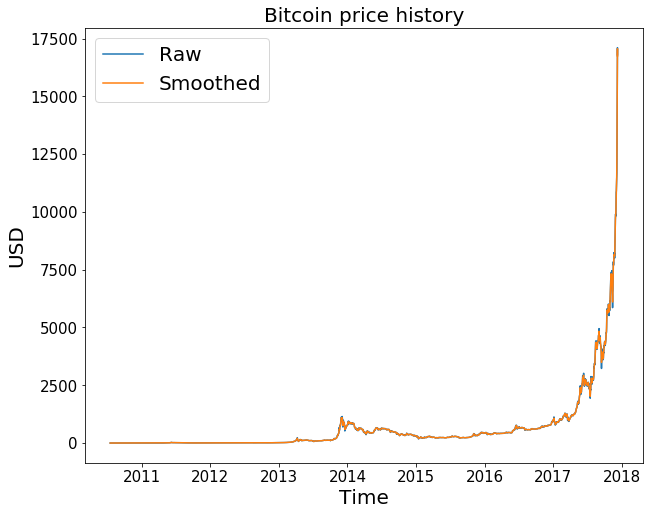

In [9]:
plt.rc('xtick', labelsize = 15)
plt.rc('ytick', labelsize = 15)

plt.figure(figsize = (10, 8))
plt.plot(eodPrice['Date'], eodPrice['Close'])
plt.plot(eodPrice['Date'], smoothed_state_means[:, 0])
plt.title('Bitcoin price history', fontsize = 20)
plt.xlabel('Time', fontsize = 20)
plt.ylabel('USD', fontsize = 20)
plt.legend(['Raw', 'Smoothed'], loc = 'upper left', fontsize = 20)
plt.show()

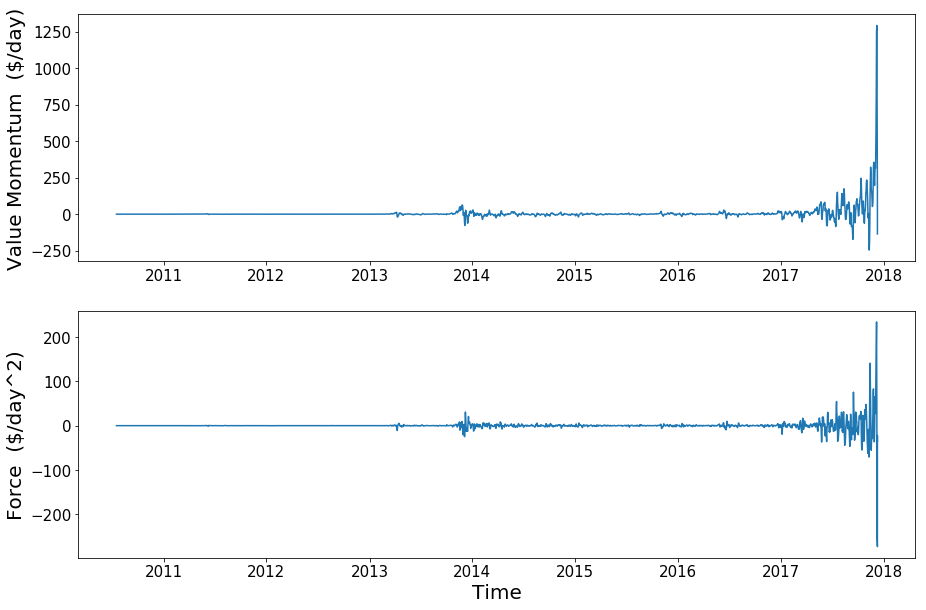

In [14]:
plt.figure(figsize = (15, 10))
plt.subplot(2, 1, 1)
plt.plot(eodPrice['Date'], smoothed_state_means[:, 1])
plt.ylabel('Value Momentum  ($/day)', fontsize = 20)

plt.subplot(2, 1, 2)
plt.plot(eodPrice['Date'], smoothed_state_means[:, 2])
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Force  ($/day^2)', fontsize = 20)
plt.show()